In [619]:
import sys
sys.path.append("../")
import numpy as np
import csv
import os
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
theodo_u = importlib.reload(theodo_u)
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.transform import Rotation as R_scipy

## Select date of the data to compute

In [620]:
# Path of output
path = "../data/20230725-1/"

## 0. Import Data & Synchronize RTS Timestamp with GNSS Timestamp

In [621]:
theodo_u = importlib.reload(theodo_u)

df_rts = pd.read_csv(path + "ground_truth/groundtruth_rts_lidar.csv", names=["Timestamp", "X", "Y", "Z", "qx", "qy", "qz", "qw"], delimiter= ' ')
df_gps = pd.read_csv(path + "ground_truth/groundtruth_gps_lidar.csv", delimiter= ',')

df_rts['Timestamp'] = pd.to_datetime(df_rts['Timestamp'], unit='s') # Convert to datetime
df_rts['Timestamp'] -= pd.Timedelta(hours=4, seconds=6) # Subtract 4 hours from the RTS Timestamp column
df_rts['Timestamp'] = df_rts["Timestamp"].values.astype(np.int64) // 10 ** 9 # Convert to Unix Timestamp

## 1. Plot GPS and RTS data

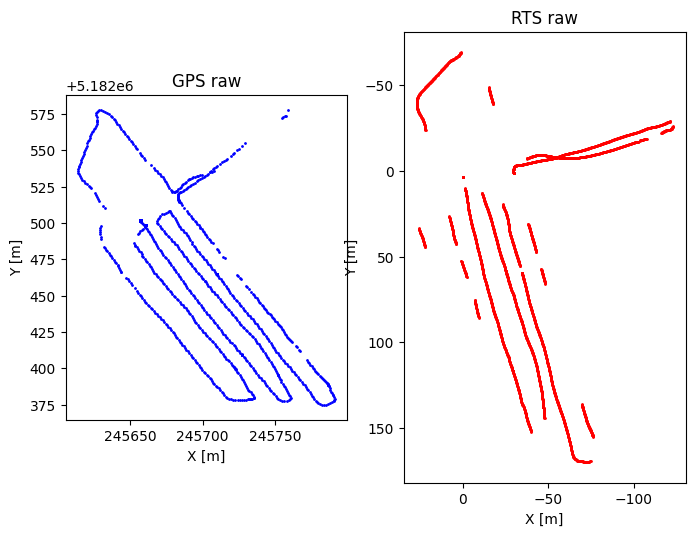

In [622]:
fig, ax = plt.subplots(figsize=(8, 8), ncols=2, nrows=1)
ax[0].scatter(df_gps['X'], df_gps['Y'], s=1, c='blue')
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS raw')
ax[0].set_aspect('equal')
ax[1].scatter(df_rts['X'], df_rts['Y'], s=1, c='red')
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].set_title('RTS raw')
ax[1].set_aspect('equal')
ax[1].invert_xaxis()
ax[1].invert_yaxis()


## 2. Compute transformation matrix from RTS frame to GNSS frame : $T_{RTS}^{GNSS}$.

In [623]:
traj_merge = pd.merge(df_rts[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw']], df_gps[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw','PDOP','Sats']], on=['Timestamp'], how='outer', indicator=True)
traj_common = traj_merge[traj_merge['_merge'] == 'both']
traj_gps_only = traj_merge[traj_merge['_merge'] == 'right_only']
traj_rts_only = traj_merge[traj_merge['_merge'] == 'left_only']

traj_common.rename(columns={'X_x':'X_rts', 'Y_x':'Y_rts', 'Z_x':'Z_rts', 'X_y':'X_gps', 'Y_y':'Y_gps', 'Z_y':'Z_gps'}, inplace=True)
traj_gps_only.rename(columns={'X_y':'X', 'Y_y':'Y', 'Z_y':'Z', 'qx_y' : 'qx', 'qy_y' : 'qy', 'qz_y' : 'qz', 'qw_y' : 'qw'}, inplace=True)
traj_rts_only.rename(columns={'X_x':'X', 'Y_x':'Y', 'Z_x':'Z', 'qx_x' : 'qx', 'qy_x' : 'qy', 'qz_x' : 'qz', 'qw_x' : 'qw'}, inplace=True)

traj_gps_only.drop(['X_x', 'Y_x', 'Z_x', 'qx_x', 'qy_x', 'qz_x', 'qw_x', '_merge'], axis=1, inplace=True)
traj_rts_only.drop(['X_y', 'Y_y', 'Z_y', 'qx_y', 'qy_y', 'qz_y', 'qw_y', 'PDOP', 'Sats', '_merge'], axis=1, inplace=True)

In [625]:
P = np.array([traj_common['X_rts'], traj_common['Y_rts'], traj_common['Z_rts'], np.ones(len(traj_common['X_rts']))])
Q = np.array([traj_common['X_gps'], traj_common['Y_gps'], traj_common['Z_gps'], np.ones(len(traj_common['X_gps']))])

T = theodo_u.point_to_point_minimization(P, Q)
P = T @ P

traj_common['X_rts'] = P[0,:]
traj_common['Y_rts'] = P[1,:]
traj_common['Z_rts'] = P[2,:]

P_rts = np.array([df_rts['X'], df_rts['Y'], df_rts['Z'],np.ones(len(df_rts['X']))])
P_rts = T @ P_rts
df_rts['X'] = P_rts[0,:]
df_rts['Y'] = P_rts[1,:]
df_rts['Z'] = P_rts[2,:]

P_traj_rts_only = np.array([traj_rts_only['X'], traj_rts_only['Y'], traj_rts_only['Z'], np.ones(len(traj_rts_only['X']))])
P_traj_rts_only = T @ P_traj_rts_only
traj_rts_only['X'] = P_traj_rts_only[0,:]
traj_rts_only['Y'] = P_traj_rts_only[1,:]
traj_rts_only['Z'] = P_traj_rts_only[2,:]

## Check timestamp sync

Text(0, 0.5, 'X [m]')

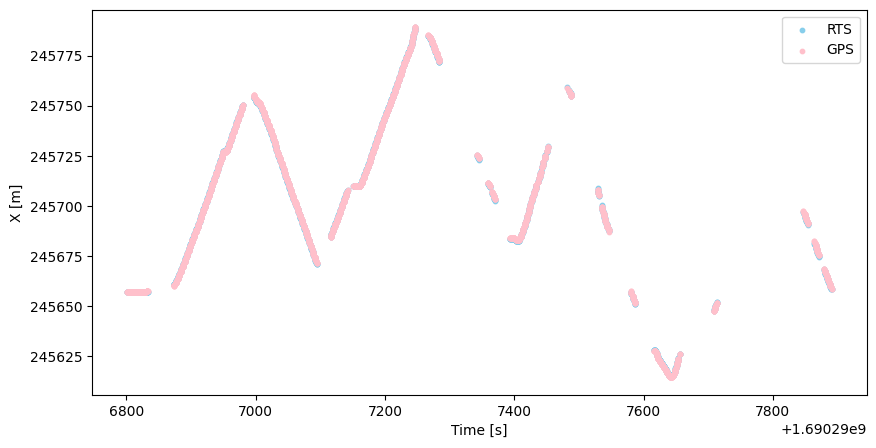

In [626]:
plt.figure(figsize=(10, 5))
plt.scatter(traj_common['Timestamp'], traj_common['X_rts'], c='skyblue', label='RTS', s=10)
plt.scatter(traj_common['Timestamp'], traj_common['X_gps'], c='pink', label='GPS', s=10)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('X [m]')

## 2. GPS only, RTS only and common trajectory

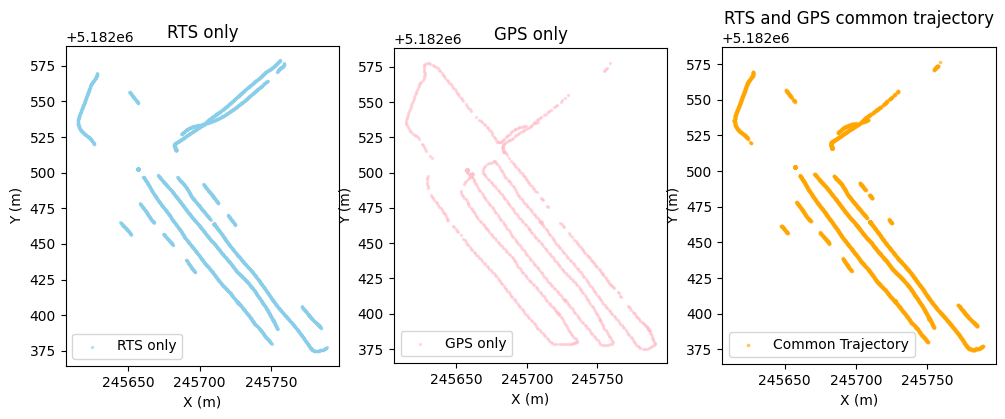

In [628]:
fig, ax = plt.subplots(figsize=(12, 12), ncols = 3, nrows = 1)
ax[0].scatter(df_rts['X'],df_rts['Y'], c='skyblue', label='RTS only', s=2, alpha = 0.5)
ax[1].scatter(df_gps['X'], df_gps['Y'], c='pink', label='GPS only', s=2, alpha=0.5)
ax[2].scatter(traj_common['X_rts'], traj_common['Y_rts'], c='orange', label='Common Trajectory', s=3, alpha=0.5)


ax[0].set_xlabel('X (m)')
ax[0].set_ylabel('Y (m)')
ax[0].set_title('RTS only')
ax[0].legend(loc = 'lower left')
ax[0].set_aspect('equal')

ax[1].set_xlabel('X (m)')
ax[1].set_ylabel('Y (m)')
ax[1].set_title('GPS only')
ax[1].legend(loc = 'lower left')
ax[1].set_aspect('equal')

ax[2].set_xlabel('X (m)')
ax[2].set_ylabel('Y (m)')
ax[2].set_title('RTS and GPS common trajectory')
ax[2].legend(loc = 'lower left')
ax[2].set_aspect('equal')


## 3. Final plot with common trajectory

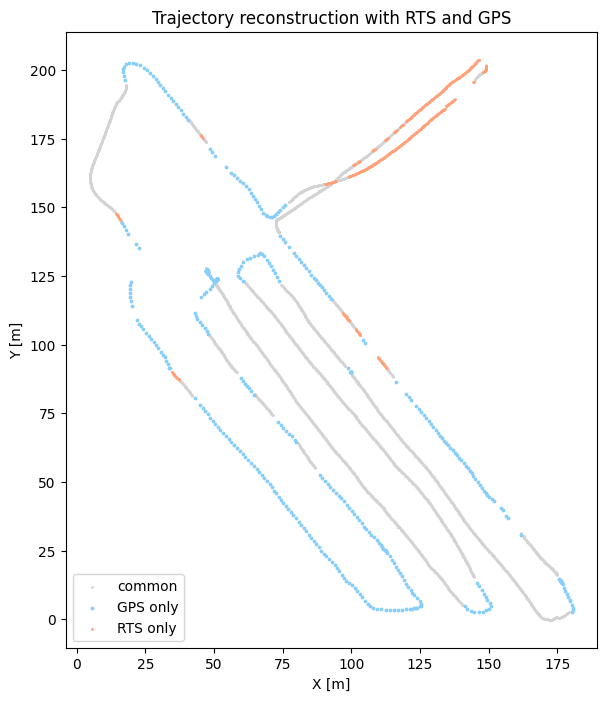

In [630]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(traj_common['X_rts']-245610, traj_common['Y_rts']-5182375, s=1, c='lightgrey', label = 'common')
ax.scatter(traj_gps_only['X']-245610, traj_gps_only['Y']-5182375, s=3, c='lightskyblue', label = 'GPS only')
ax.scatter(traj_rts_only['X']-245610, traj_rts_only['Y']-5182375, s=1, c='lightsalmon', label = 'RTS only')
ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title('Trajectory reconstruction with RTS and GPS')
ax.set_aspect('equal')

## 5. Final comparaison between raw data and trajectory reconstruction

In [631]:
X_origin = 245610
Y_origin = 5182375

Text(0.5, 0.68, 'First trajectory')

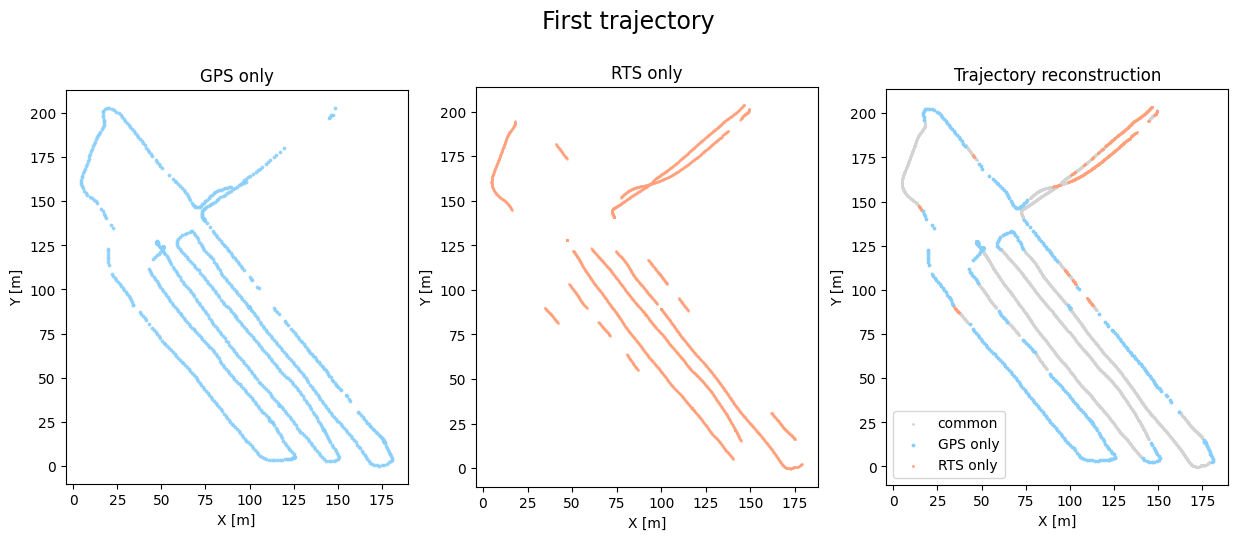

In [632]:
fig, ax = plt.subplots(figsize=(15, 15), ncols=3, nrows=1)

ax[0].scatter(df_gps['X']-X_origin, df_gps['Y']-Y_origin, s=3, c='lightskyblue', alpha=0.8)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS only')
ax[0].set_aspect('equal')

ax[1].scatter(df_rts['X']-X_origin, df_rts['Y']-Y_origin, s=1, c='lightsalmon', alpha=0.5)
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].set_title('RTS only')
ax[1].set_aspect('equal')

ax[2].scatter(traj_common['X_rts']-X_origin, traj_common['Y_rts']-Y_origin, s=1, c='lightgrey', label = 'common')
ax[2].scatter(traj_gps_only['X']-X_origin, traj_gps_only['Y']-Y_origin, s=3, c='lightskyblue', label = 'GPS only')
ax[2].scatter(traj_rts_only['X']-X_origin, traj_rts_only['Y']-Y_origin, s=1, c='lightsalmon', label = 'RTS only')
ax[2].set_aspect('equal')
ax[2].legend()
ax[2].set_xlabel('X [m]')
ax[2].set_ylabel('Y [m]')
ax[2].set_title('Trajectory reconstruction')
ax[2].set_aspect('equal')

fig.suptitle('First trajectory',fontsize=17, y=0.68)

# Figure : precision GPS and RTS

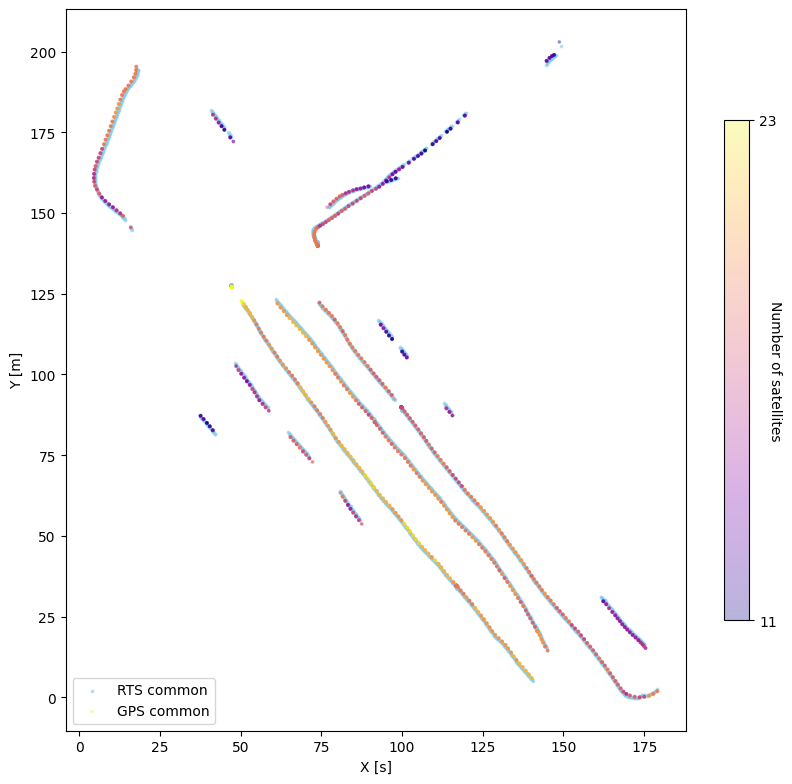

In [659]:
plt.figure(figsize=(10,10))
plt.scatter(traj_common['X_rts'] - X_origin, traj_common['Y_rts'] - Y_origin, c='skyblue', label='RTS common', s=3, alpha=0.5)
plt.scatter(traj_common['X_gps'] - X_origin, traj_common['Y_gps'] - Y_origin, cmap = 'plasma', c=traj_common['Sats'], label='GPS common', s=3, alpha=0.3)
plt.gca().set_aspect('equal')
plt.legend(loc = 'lower left')
plt.xlabel('X [s]')
plt.ylabel('Y [m]')

colorbar = plt.colorbar(shrink=0.65)
colorbar.set_label('Number of satellites', rotation=270)
colorbar.set_ticks([min(traj_common['Sats']), max(traj_common['Sats'])])

## Interpolate the trajectory with norlab_trajectory

In [636]:
#import norlab_trajectory_python as trajpy

## To merge images :

In [634]:
from PIL import Image
def merge_images_vertically(image_path1, image_path2, output_path):
    # Ouvrir les deux images
    image1 = Image.open(image_path1)
    image2 = Image.open(image_path2)

    # Récupérer les dimensions des images
    width1, height1 = image1.size
    width2, height2 = image2.size

    # Calculer la largeur et la hauteur de l'image fusionnée
    merged_width = max(width1, width2)
    merged_height = height1 + height2

    # Créer une nouvelle image fusionnée
    merged_image = Image.new("RGB", (merged_width, merged_height), (255, 255, 255))

    # Coller les deux images dans l'image fusionnée
    merged_image.paste(image1, (0, 0))
    merged_image.paste(image2, (0, height1))

    # Enregistrer l'image fusionnée
    merged_image.save(output_path)

merge_images_vertically("/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_1st.png", "/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_2nd.png", "/Users/effiedaum/Master_thesis/Figures/Plot_workshop/final_plot_merged.png")